# 2021-09-01 Boundaries and Fourier methods

## Last time
* High order on arbitrary grids
* Method of manufactured solutions
* More satisfying approach to boundary conditions

## Today
* More on boundary conditions
* Fourier methods for analyzing finite difference methods
* Discussion

In [1]:
using Plots
using LinearAlgebra

# Interpolation by Vandermonde matrices

We can compute a polynomial

$$ p(x) = c_0 + c_1 x + c_2 x^2 + \dotsb $$

that assumes function values $p(x_i) = u_i$ by solving a linear system with the Vandermonde matrix.

$$ \underbrace{\begin{bmatrix} 1 & x_0 & x_0^2 & \dotsb \\
    1 & x_1 & x_1^2 & \dotsb \\
    1 & x_2 & x_2^2 & \dotsb \\
    \vdots & & & \ddots \end{bmatrix}}_V \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ \vdots \end{bmatrix} = \begin{bmatrix} u_0 \\ u_1 \\ u_2 \\ \vdots \end{bmatrix} .$$

In [2]:
function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

vander (generic function with 2 methods)

In [3]:
vander(LinRange(-1, 1, 5))

5×5 Matrix{Float64}:
 1.0  -1.0  1.0   -1.0    1.0
 1.0  -0.5  0.25  -0.125  0.0625
 1.0   0.0  0.0    0.0    0.0
 1.0   0.5  0.25   0.125  0.0625
 1.0   1.0  1.0    1.0    1.0

# Arbitrary order derivatives

In [4]:
function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end
x = LinRange(-2, 2, 4)
u = sin.(x)
fdstencil(x, 0.5, 2)


1×4 adjoint(::Vector{Float64}) with eltype Float64:
 0.0703125  0.351563  -0.914062  0.492188

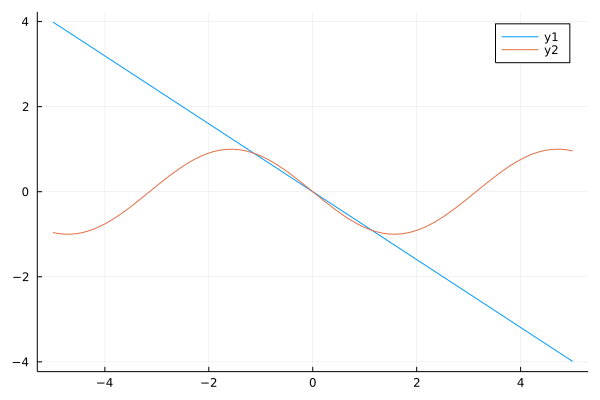

In [5]:
plot([z -> fdstencil(x, z, 2) * u,
        z -> -sin(z)]) 

# High order discretization of the Laplacian
## The Poisson problem $-u_{xx} = f$ with boundary conditions

In [6]:
function poisson(x, spoints, forcing; left=(0, zero), right=(0, zero))
    n = length(x)
    L = zeros(n, n)
    rhs = forcing.(x)
    for i in 2:n-1
        jleft = min(max(1, i-spoints÷2), n-spoints+1)
        js = jleft : jleft + spoints - 1
        L[i, js] = -fdstencil(x[js], x[i], 2)
    end
    L[1,1:spoints] = fdstencil(x[1:spoints], x[1], left[1])
    L[n,n-spoints+1:n] = fdstencil(x[n-spoints+1:n], x[n], right[1])
    rhs[1] = left[2](x[1])
    rhs[n] = right[2](x[n])
    L, rhs
end

poisson (generic function with 1 method)

In [7]:
L, b = poisson(LinRange(-1, 1, 6), 3, zero, left=(1, zero))
L

6×6 Matrix{Float64}:
 -3.75   5.0   -1.25   0.0           0.0           0.0
 -6.25  12.5   -6.25   0.0           0.0           0.0
  0.0   -6.25  12.5   -6.25          0.0           0.0
  0.0    0.0   -6.25  12.5          -6.25          0.0
  0.0    0.0    0.0   -6.25         12.5          -6.25
  0.0    0.0    0.0    9.25186e-18  -2.31296e-16   1.0

# Method of manufactured solutions

## Problem: analytic solutions to PDEs are hard to find

Let's choose a smooth function with rich derivatives,
$$ u(x) = \tanh(x) . $$
Then $$ u'(x) = \cosh^{-2}(x) $$ and $$ u''(x) = -2 \tanh(x) \cosh^{-2}(x) . $$

* This works for nonlinear too.

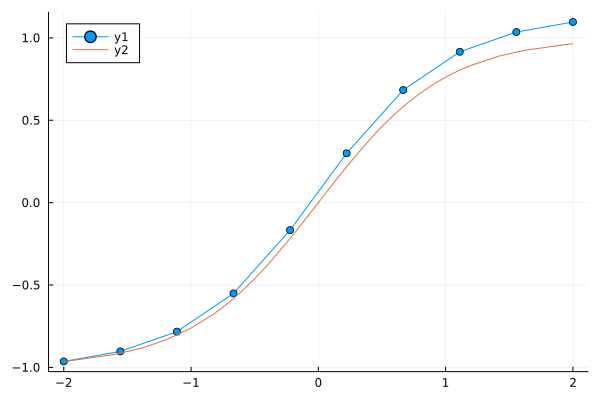

In [8]:
x = LinRange(-2, 2, 10)
L, rhs = poisson(x, 3,
    x -> 2 * tanh(x) / cosh(x)^2,
    left=(0, tanh), 
    right=(1, x -> cosh(x)^-2))
u = L \ rhs
plot(x, u, marker=:circle, legend=:topleft)
plot!(tanh)

# Convergence rate

In [9]:
ns = 2 .^ (2:10)
hs = 1 ./ ns
function poisson_error(n)
    x = LinRange(-2, 2, n)
    L, rhs = poisson(x, 3, x -> 2 * tanh(x) / cosh(x)^2,
        left = (0, tanh),
        right = (1, x -> cosh(x)^-2))
    u = L \ rhs
    norm(u - tanh.(x), Inf)
end

poisson_error (generic function with 1 method)

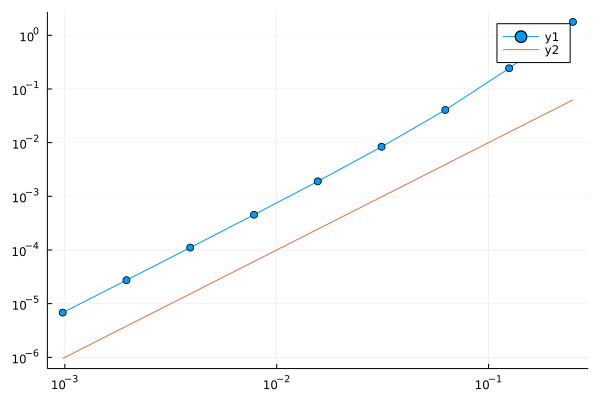

In [10]:
plot(hs, [poisson_error(n) for n in ns], marker=:circle)
plot!(h -> h^2, xscale=:log10, yscale=:log10)

# Symmetry in boundary conditions: Dirichlet

We have implemented Dirichlet conditions by modifying the first row of the matrix,
$$ \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ \\ & & A_{1:,:} & & \\ \\ \end{bmatrix} \begin{bmatrix} u_0 \\ \\ u_{1:} \\ \\ \end{bmatrix} = \begin{bmatrix} a \\ \\ f_{1:} \\ \\ \end{bmatrix} . $$

* This matrix is not symmetric even if $A$ is.
* We can eliminate $u_0$ and create a reduced system for $u_{1:}$.
* Generalize: consider a $2\times 2$ block system
$$ \begin{bmatrix} I & 0 \\ A_{10} & A_{11} \end{bmatrix} \begin{bmatrix} u_0 \\ u_1 \end{bmatrix} = \begin{bmatrix} f_0 \\ f_1 \end{bmatrix} .$$

We can rearrange as
$$ A_{11} u_1 = f_1 - A_{10} f_0, $$
which is symmetric if $A_{11}$ is.
* This is called "lifting" and is often done implicitly in the mathematics literature.  It is convenient for linear solvers and eigenvalue solvers, but inconvenient for IO and postprocessing, as well as some nonlinear problems.
* Convenient alternative: write
$$ \begin{bmatrix} I & 0 \\ 0 & A_{11} \end{bmatrix} \begin{bmatrix} u_0 \\ u_1 \end{bmatrix} = \begin{bmatrix} f_0 \\ f_1 - A_{10} f_0 \end{bmatrix}, $$
which is symmetric and decouples the degrees of freedom associated with the boundary. This method applies cleanly to nonlinear problems.
* Optionally scale the identity by some scalar related to the norm of $A_{11}$.

# Symmetry in boundary conditions: Neumann

Consider FD discretization of the Neumann boundary condition
$$ \frac{du}{dx}(1) = b . $$
1. Use a one-sided difference formula as in
$$ \frac{u_n - u_{n-1}}{h} = b . $$
  * an extra discretization choice
  * may reduce order of accuracy compared to interior discretization, lose symmetry.
2. Temporarily introduce a ghost value $u_{n+1} = u(x_{n+1} = 1 + h)$ (possibly more) and define it to be a reflection of the values from inside the domain.  In the case $b=0$, this reflection is $u_{n+i} = u_{n-i}$.  More generally,
$$ u_{n+i} = u_{n-i} + 2b(x_n - x_{n-i}) . $$

After this definition of ghost values, we apply the interior discretization at the boundary. For our reference equation, we would write

$$ \frac{-u_{n-1} + 2 u_n - u_{n+1}}{h^2} = f(x_n) $$

which simplifies to $$ \frac{u_n - u_{n-1}}{h^2} = f(x_n)/2 + b/h $$
after dividing by 2 and moving the boundary term to the right hand side.

# Fourier analysis of stencils

Consider the plane waves $\phi(x, \theta) = e^{i\theta x}$.

Sample $\phi$ on a discrete grid $x = \mathbb Z$ and apply the stencil
\begin{align}
S \phi(x, \theta) &= s_{-1} \phi(x-1, \theta) + s_{0} \phi(x, \theta) + s_1 \phi(x+1,\theta) \\
&= \Big( s_{-1} e^{-i\theta} + s_0 + s_{1} e^{i\theta} \Big) \phi(x, \theta)
\end{align}
With $S = \begin{bmatrix} -1 & 2 & -1 \end{bmatrix}$, we get
$$S \phi(x, \theta) = \underbrace{(2 - 2 \cos\theta)}_{\hat S(\theta)} \phi(x, \theta)$$
We call $\hat S(\theta)$ the *symbol* of the operator.
What is the symbol of the continuous second derivative?

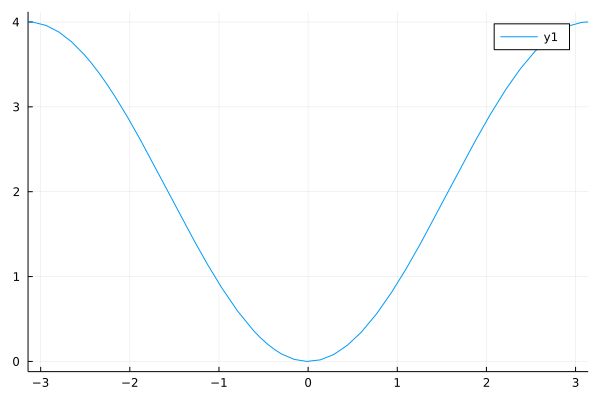

In [11]:
plot(theta -> 2 - 2*cos(theta), xlims=(-pi, pi))

# Numerically computing symbols

In [32]:
function symbol(S, theta)
    if length(S) % 2 != 1
        error("Length of stencil must be odd")
    end
    w = length(S) ÷ 2
    phi = exp.(1im * (-w:w) * theta')
    vec(S * phi) # not! (S * phi)'
end

symbol([-.5 0 .5], LinRange(-pi, pi, 10))

10-element Vector{ComplexF64}:
 0.0 - 1.2246467991473532e-16im
 0.0 - 0.6427876096865395im
 0.0 - 0.9848077530122081im
 0.0 - 0.8660254037844388im
 0.0 - 0.34202014332566877im
 0.0 + 0.34202014332566877im
 0.0 + 0.8660254037844385im
 0.0 + 0.9848077530122081im
 0.0 + 0.6427876096865395im
 0.0 + 1.2246467991473532e-16im

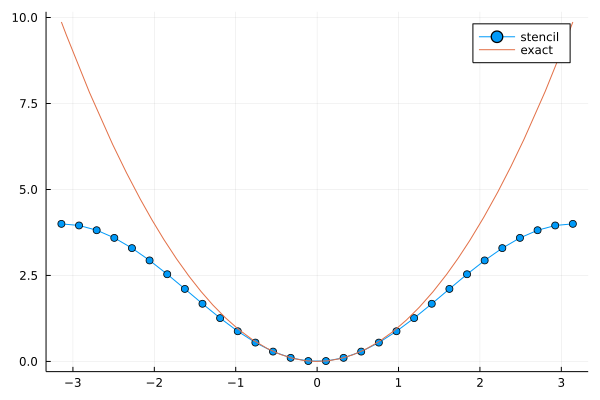

In [34]:
function plot_symbol(S, deriv, n_theta=30)
    theta = LinRange(-pi, pi, n_theta)
    sym = symbol(S, theta)
    rsym = real.((-1im)^deriv * sym)
    fig = plot(theta, rsym, marker=:circle, label="stencil")
    plot!(fig, th -> th^deriv, label="exact")
    fig
end

plot_symbol([-.5 0 .5], 1)
plot_symbol([1 -2 1], 2)

# Stencils of high-order operators

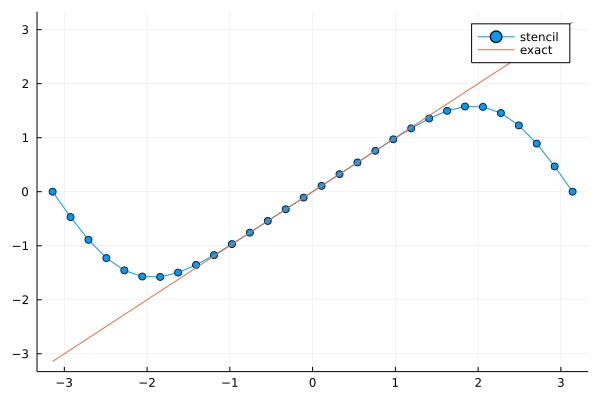

In [38]:
x = -3:3
plot_symbol(fdstencil(x, 0, 1), 1)

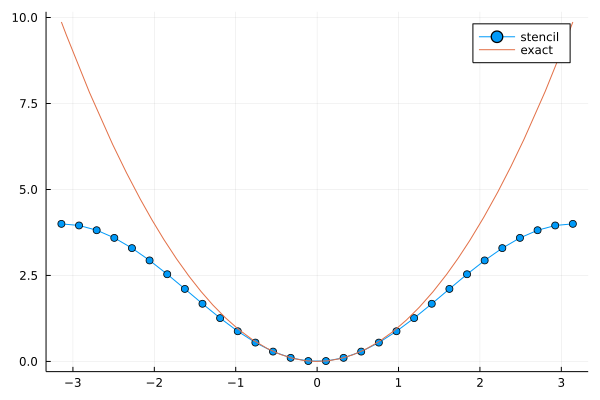

In [42]:
x = -1:1
plot_symbol(fdstencil(x, 0, 2), 2)